Unmasked image not found for: image_03.jpg, skipping.
Loaded 2 images and 2 binary masks.


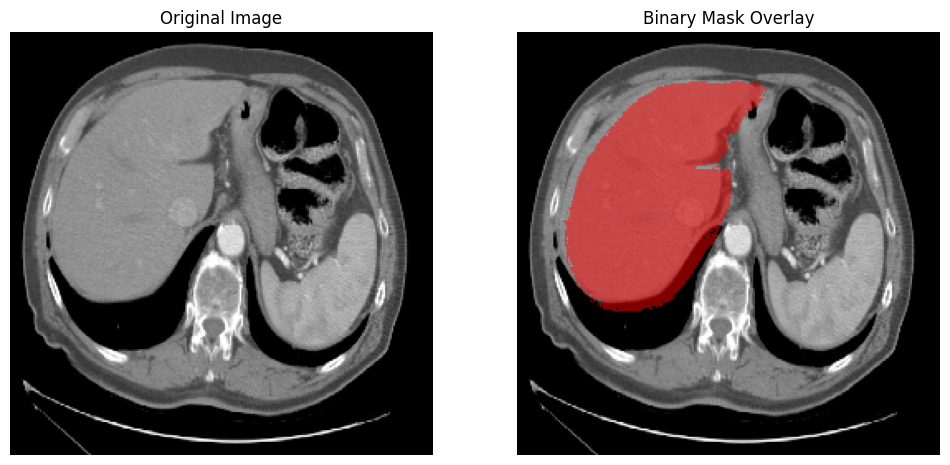

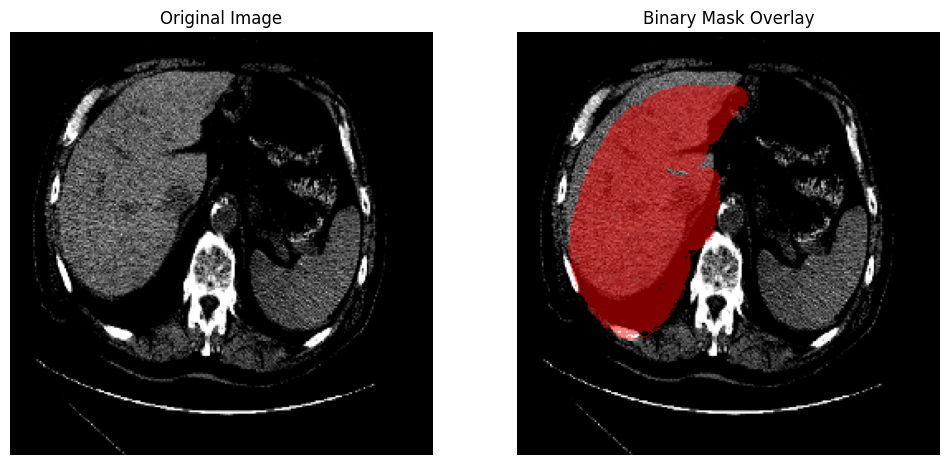

In [6]:
import os
import numpy as np
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image

def extract_binary_mask(mask_image, red_threshold=150):
    """
    Extract binary mask from a red-labeled mask image.

    Parameters:
    - mask_image: RGB mask image as a NumPy array.
    - red_threshold: Minimum red value to classify as part of the mask.

    Returns:
    - Binary mask as a NumPy array.
    """
    # Separate the red, green, and blue channels
    red_channel = mask_image[..., 0]
    green_channel = mask_image[..., 1]
    blue_channel = mask_image[..., 2]
    
    # Create a binary mask where red is dominant
    binary_mask = (red_channel > red_threshold) & (green_channel < red_threshold) & (blue_channel < red_threshold)
    return binary_mask.astype(np.float32)  # Convert to float for consistency

def apply_binary_mask(image, binary_mask, color=(255, 0, 0), alpha=0.5):
    """
    Apply binary mask as a color overlay to a grayscale image.

    Parameters:
    - image: Grayscale image as a NumPy array.
    - binary_mask: Binary mask (values in range [0, 1]).
    - color: Tuple representing RGB color of the mask.
    - alpha: Transparency of the mask (0 = transparent, 1 = opaque).

    Returns:
    - Color-masked image as a NumPy array.
    """
    # Convert grayscale image to RGB
    image_rgb = np.stack([image.squeeze()] * 3, axis=-1)  # Convert to (H, W, 3)
    image_rgb = (image_rgb * 255).astype(np.uint8)  # Scale to [0, 255]
    
    # Create a color layer with the specified color
    color_layer = np.zeros_like(image_rgb)
    color_layer[..., 0] = color[0]  # Red channel
    color_layer[..., 1] = color[1]  # Green channel
    color_layer[..., 2] = color[2]  # Blue channel
    
    # Apply the color mask
    masked_image = image_rgb * (1 - alpha * binary_mask[..., None]) + color_layer * (alpha * binary_mask[..., None])
    return masked_image.astype(np.uint8)

# Define directories
masked_dir = r'/Users/mohammedatheefga/M_tech/vs code/Project 02/Liver Countour'
unmasked_dir = r'/Users/mohammedatheefga/M_tech/vs code/Project 02/uncountoured'

# Function to load and process images
def load_images_and_masks(input_dir, mask_dir, target_size=(256, 256)):
    inputs, binary_masks = [], []
    
    for filename in os.listdir(mask_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            mask_path = os.path.join(mask_dir, filename)
            input_path = os.path.join(input_dir, filename)
            
            # Check if corresponding unmasked image exists
            if not os.path.exists(input_path):
                print(f"Unmasked image not found for: {filename}, skipping.")
                continue
            
            # Load and preprocess unmasked image (grayscale)
            img = load_img(input_path, target_size=target_size, color_mode='grayscale')
            img = img_to_array(img) / 255.0  # Normalize to [0, 1]
            inputs.append(img)
            
            # Load and preprocess masked image (RGB)
            mask = load_img(mask_path, target_size=target_size, color_mode='rgb')
            mask = img_to_array(mask)
            
            # Extract binary mask from red-labeled areas
            binary_mask = extract_binary_mask(mask)
            binary_masks.append(binary_mask)
    
    return np.array(inputs), np.array(binary_masks)

# Load images and masks
input_images, binary_masks = load_images_and_masks(unmasked_dir, masked_dir)

# Verify loaded data
print(f"Loaded {len(input_images)} images and {len(binary_masks)} binary masks.")

# Visualize original images with binary mask overlay
def visualize_binary_mask_overlay(images, masks, num_samples=3, color=(255, 0, 0)):
    for i in range(min(num_samples, len(images))):
        # Apply binary mask as a color overlay
        color_masked_image = apply_binary_mask(images[i], masks[i], color=color, alpha=0.5)
        
        # Plot original and masked images
        plt.figure(figsize=(12, 6))
        
        # Show original grayscale image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # Show image with binary mask overlay
        plt.subplot(1, 2, 2)
        plt.imshow(color_masked_image)
        plt.title("Binary Mask Overlay")
        plt.axis('off')
        
        plt.show()

# Visualize the first few samples
visualize_binary_mask_overlay(input_images, binary_masks, num_samples=3, color=(255, 0, 0))


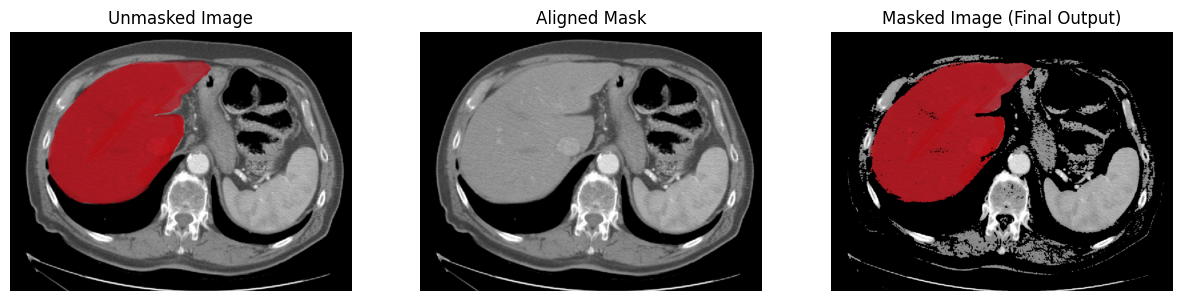

Masked image saved at: masked_output.jpg


In [20]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to Align Images
def align_images(fixed_image_path, moving_image_path):
    """
    Aligns the moving image (masked) to the fixed image (unmasked).
    Uses ORB feature matching and homography transformation.
    """
    # Read images
    fixed_img = cv2.imread(fixed_image_path)
    moving_img = cv2.imread(moving_image_path)
    
    # Convert to grayscale
    fixed_gray = cv2.cvtColor(fixed_img, cv2.COLOR_BGR2GRAY)
    moving_gray = cv2.cvtColor(moving_img, cv2.COLOR_BGR2GRAY)
    
    # Detect ORB features and descriptors
    orb = cv2.ORB_create(5000)
    keypoints1, descriptors1 = orb.detectAndCompute(fixed_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(moving_gray, None)
    
    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Extract matched keypoints
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    
    # Compute homography matrix
    h, _ = cv2.findHomography(points2, points1, cv2.RANSAC)
    
    # Warp moving image to align with fixed image
    height, width, _ = fixed_img.shape
    aligned_img = cv2.warpPerspective(moving_img, h, (width, height))
    return aligned_img, fixed_img

# Function to Apply Mask
def apply_mask(unmasked_image, aligned_mask):
    """
    Applies the binary mask to the unmasked image to highlight the liver.
    """
    # Convert mask to binary (red channel threshold)
    mask_binary = aligned_mask[:, :, 2] > 128  # Extract red channel
    mask_binary = mask_binary.astype(np.uint8)  # Convert to 0 or 1
    
    # Apply mask to the unmasked image
    masked_image = unmasked_image.copy()
    for c in range(3):  # Apply to each channel
        masked_image[:, :, c] *= mask_binary
    
    return masked_image

# Function to Visualize Results
def visualize_results(unmasked, aligned_mask, final_masked):
    """
    Displays the unmasked image, aligned mask, and final masked image.
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(unmasked, cv2.COLOR_BGR2RGB))
    plt.title("Unmasked Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(aligned_mask, cv2.COLOR_BGR2RGB))
    plt.title("Aligned Mask")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(final_masked, cv2.COLOR_BGR2RGB))
    plt.title("Masked Image (Final Output)")
    plt.axis('off')
    
    plt.show()

# Main Workflow
def main_workflow(unmasked_path, masked_path):
    """
    Main workflow to align images, apply the mask, and visualize results.
    """
    # Align the masked image to the unmasked image
    aligned_mask, unmasked_image = align_images(unmasked_path, masked_path)
    
    # Apply the aligned mask to the unmasked image
    final_masked_image = apply_mask(unmasked_image, aligned_mask)
    
    # Visualize results
    visualize_results(unmasked_image, aligned_mask, final_masked_image)

    # Save results
    output_path = "masked_output.jpg"
    cv2.imwrite(output_path, final_masked_image)
    print(f"Masked image saved at: {output_path}")

# Example Usage
unmasked_path = '/Users/mohammedatheefga/M_tech/vs code/Project 02/Liver Countour/image_01.jpg'  # Replace with the actual path
masked_path = '/Users/mohammedatheefga/M_tech/vs code/Project 02/uncountoured/image_01.jpg'      # Replace with the actual path

main_workflow(unmasked_path, masked_path)
